In [1]:
pip install -q findspark

Note: you may need to restart the kernel to use updated packages.


In [2]:
import findspark
findspark.init('/home/bigdata/Documents/spark-3.0.0')

In [3]:
import pandas as pd
import numpy as np
from pyspark.sql.session import SparkSession
import matplotlib.pyplot as plt
import os
import pyspark
from sklearn.utils import shuffle
import pyspark.sql.functions as f
import pickle

In [4]:
spark = SparkSession.builder.appName('mykmean').getOrCreate()

In [5]:
from pyspark.sql.types import StructType
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import ByteType
from pyspark.sql.types import FloatType
from pyspark.sql.types import BinaryType
from pyspark.sql.types import DataType
from pyspark.sql.types import StructField
from pyspark.sql.types import Row


schema = StructType([ StructField("srcip", StringType(), True),   
    StructField("sport", IntegerType(), True),  
    StructField("dstip", StringType(), True),   
    StructField("dsport", IntegerType(), True), 
    StructField("proto", StringType(), True),  
    StructField("state", StringType(), True),
    StructField("dur", FloatType(), True),       
    StructField("sbytes", ByteType(), True),    
    StructField("dbytes", ByteType(), True),    
    StructField("sttl", IntegerType(), True), 
    StructField("dttl", IntegerType(), True),   
    StructField("sloss", IntegerType(), True),
    StructField("dloss", IntegerType(), True),
    StructField("service", StringType(), True),    
    StructField("Sload", FloatType(), True),  
    StructField("Dload", FloatType(), True), 
    StructField("Spkts", IntegerType(), True),    
    StructField("Dpkts", IntegerType(), True),    
    StructField("swin", IntegerType(), True),
    StructField("dwin", IntegerType(), True), 
    StructField("stcpb", IntegerType(), True),  
    StructField("dtcpb", IntegerType(), True),    
    StructField("smeansz", IntegerType(), True),   
    StructField("dmeansz", IntegerType(), True),  
    StructField("trans_depth", IntegerType(), True),  
    StructField("res_bdy_len", IntegerType(), True),    
    StructField("Sjit", FloatType(), True),    
    StructField("Djit", FloatType(), True),     
    StructField("Stime", IntegerType(), True), 
    StructField("Ltime", IntegerType(), True),   
    StructField("Sintpkt", FloatType(), True),
    StructField("Dintpkt", FloatType(), True),    
    StructField("tcprtt", FloatType(), True),  
    StructField("synack", FloatType(), True),    
    StructField("ackdat", FloatType(), True),  
    StructField("is_sm_ips_ports", IntegerType(), True),    
    StructField("ct_state_ttl", IntegerType(), True), 
    StructField("ct_flw_http_mthd", IntegerType(), True), 
    StructField("is_ftp_login", IntegerType(), True),  
    StructField("ct_ftp_cmd", IntegerType(), True),
    StructField("ct_srv_src", IntegerType(), True),    
    StructField ("ct_srv_dst", IntegerType(), True),  
    StructField("ct_dst_ltm", IntegerType(), True),   
    StructField("ct_src_ltm", IntegerType(), True),    
    StructField("ct_src_dport_ltm", IntegerType(), True),    
    StructField("ct_dst_sport_ltm", IntegerType(), True),  
    StructField("ct_dst_src_ltm", IntegerType(), True),  
    StructField("attack_cat", StringType(), True),    
    StructField("Label", IntegerType(), True) 
    
])

In [6]:
df_schema = spark.read.format("csv").option("header", "True").schema(schema).load("/home/bigdata/UNSW-NB15.csv")

In [7]:
#show columns with values
df_schema.show()

+----------+-----+-------------+------+-----+-----+--------+------+------+----+----+-----+-----+--------+---------+---------+-----+-----+----+----+----------+----------+-------+-------+-----------+-----------+---------+---------+----------+----------+---------+---------+-------+-------+-------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+----------+-----+
|     srcip|sport|        dstip|dsport|proto|state|     dur|sbytes|dbytes|sttl|dttl|sloss|dloss| service|    Sload|    Dload|Spkts|Dpkts|swin|dwin|     stcpb|     dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|     Sjit|     Djit|     Stime|     Ltime|  Sintpkt|  Dintpkt| tcprtt| synack| ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|
+----------+-----+-------------+------+-----+---

In [8]:
#drop columnn with ip address, port and unix time
df_schema = df_schema.drop("srcip", "sport", "dstip", "dsport", "stime", "ltime", "Label")

In [9]:
from pyspark.sql.functions import col, Column, lit, when, regexp_replace

In [10]:
#remove blank space in column value
df_schema = df_schema.withColumn('attack_cat', regexp_replace(col('attack_cat'), " ", ""))

In [11]:
#replace Backdoor with Backdoors
df_schema=df_schema.replace("Backdoor", "Backdoors")

In [12]:
#replace blank space in column attack_cat with Normal
df_schem = df_schema.fillna({"attack_cat": 'Normal'})

In [13]:
#show attack entries with attack_cat
df_schem.select('attack_cat').distinct().show()

+--------------+
|    attack_cat|
+--------------+
|         Worms|
|     Shellcode|
|     Backdoors|
|       Fuzzers|
|      Analysis|
|           DoS|
|Reconnaissance|
|      Exploits|
|        Normal|
|       Generic|
+--------------+



In [14]:
final_data=df_schem.na.drop()

In [15]:
final_data.show()

+-----+-----+---------+------+------+----+----+-----+-----+-------+--------+---------+-----+-----+----+----+-----+-----+-------+-------+-----------+-----------+--------+--------+---------+---------+------+------+------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+----------+
|proto|state|      dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|   Sload|    Dload|Spkts|Dpkts|swin|dwin|stcpb|dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|    Sjit|    Djit|  Sintpkt|  Dintpkt|tcprtt|synack|ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|
+-----+-----+---------+------+------+----+----+-----+-----+-------+--------+---------+-----+-----+----+----+-----+-----+-------+-------+-----------+-----------+--------+--------+---------+---------+------+------+

In [16]:
from pyspark.ml.feature import(VectorAssembler, VectorIndexer, OneHotEncoder, StringIndexer)

assembler = VectorAssembler(inputCols=['dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm'], outputCol='features')

In [17]:
main_data=assembler.transform(final_data)

In [18]:
main_data.show(5)

+-----+-----+---------+------+------+----+----+-----+-----+-------+--------+---------+-----+-----+----+----+-----+-----+-------+-------+-----------+-----------+----+----+---------+---------+------+------+------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+----------+--------------------+
|proto|state|      dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|   Sload|    Dload|Spkts|Dpkts|swin|dwin|stcpb|dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|Sjit|Djit|  Sintpkt|  Dintpkt|tcprtt|synack|ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|            features|
+-----+-----+---------+------+------+----+----+-----+-----+-------+--------+---------+-----+-----+----+----+-----+-----+-------+-------+-----------+-----------+----+----+---------+------

In [19]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StandardScaler

In [20]:
scaler = StandardScaler(inputCol= 'features', outputCol = 'scaledFeatures')

In [21]:
scaler_model =scaler.fit(main_data)
cluster_final_data =scaler_model.transform(main_data)

In [22]:
cluster_final_data.printSchema()

root
 |-- proto: string (nullable = true)
 |-- state: string (nullable = true)
 |-- dur: float (nullable = true)
 |-- sbytes: byte (nullable = true)
 |-- dbytes: byte (nullable = true)
 |-- sttl: integer (nullable = true)
 |-- dttl: integer (nullable = true)
 |-- sloss: integer (nullable = true)
 |-- dloss: integer (nullable = true)
 |-- service: string (nullable = true)
 |-- Sload: float (nullable = true)
 |-- Dload: float (nullable = true)
 |-- Spkts: integer (nullable = true)
 |-- Dpkts: integer (nullable = true)
 |-- swin: integer (nullable = true)
 |-- dwin: integer (nullable = true)
 |-- stcpb: integer (nullable = true)
 |-- dtcpb: integer (nullable = true)
 |-- smeansz: integer (nullable = true)
 |-- dmeansz: integer (nullable = true)
 |-- trans_depth: integer (nullable = true)
 |-- res_bdy_len: integer (nullable = true)
 |-- Sjit: float (nullable = true)
 |-- Djit: float (nullable = true)
 |-- Sintpkt: float (nullable = true)
 |-- Dintpkt: float (nullable = true)
 |-- tcprtt: f

In [23]:
kmeans = KMeans(featuresCol = 'scaledFeatures' , k=10)

In [24]:
model = kmeans.fit(cluster_final_data)

In [25]:
prediction = model.transform(cluster_final_data)

In [26]:
prediction.groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|         1|  1969|
|         6|  4939|
|         3|     1|
|         5| 45545|
|         9| 51221|
|         4|    14|
|         8|    43|
|         7|    54|
|         2|  2621|
|         0|119587|
+----------+------+



In [27]:
prediction.select('prediction', 'attack_cat').show()

+----------+----------+
|prediction|attack_cat|
+----------+----------+
|         2|    Normal|
|         2|    Normal|
|         2|    Normal|
|         2|    Normal|
|         6|    Normal|
|         6|    Normal|
|         6|    Normal|
|         6|    Normal|
|         2|    Normal|
|         2|    Normal|
|         6|    Normal|
|         6|    Normal|
|         6|    Normal|
|         6|    Normal|
|         2|    Normal|
|         2|    Normal|
|         2|    Normal|
|         2|    Normal|
|         2|    Normal|
|         2|    Normal|
+----------+----------+
only showing top 20 rows



In [28]:
prediction.select('scaledFeatures', 'features' ,'prediction').show()

+--------------------+--------------------+----------+
|      scaledFeatures|            features|prediction|
+--------------------+--------------------+----------+
|(38,[0,1,2,7,8,9,...|(38,[0,1,2,7,8,9,...|         2|
|(38,[0,1,2,7,8,9,...|(38,[0,1,2,7,8,9,...|         2|
|(38,[1,2,7,8,9,10...|(38,[1,2,7,8,9,10...|         2|
|(38,[1,2,7,8,9,10...|(38,[1,2,7,8,9,10...|         2|
|(38,[1,9,15,26,27...|(38,[1,9,15,26,27...|         6|
|(38,[1,9,15,26,27...|(38,[1,9,15,26,27...|         6|
|(38,[1,9,15,26,27...|(38,[1,9,15,26,27...|         6|
|(38,[1,9,15,26,27...|(38,[1,9,15,26,27...|         6|
|(38,[1,2,7,8,9,10...|(38,[1,2,7,8,9,10...|         2|
|(38,[1,2,7,8,9,10...|(38,[1,2,7,8,9,10...|         2|
|(38,[1,9,15,21,26...|(38,[1,9,15,21,26...|         6|
|(38,[1,9,15,21,26...|(38,[1,9,15,21,26...|         6|
|(38,[1,9,15,21,26...|(38,[1,9,15,21,26...|         6|
|(38,[1,9,15,21,26...|(38,[1,9,15,21,26...|         6|
|(38,[0,1,2,7,8,9,...|(38,[0,1,2,7,8,9,...|         2|
|(38,[0,1,

In [29]:
from pyspark.ml.evaluation import ClusteringEvaluator

In [30]:
evaluator = ClusteringEvaluator()

In [31]:
#Evaluating Clustering by computing within Set Sum of Sqaured Errors

silhouette = evaluator.evaluate(model.transform(cluster_final_data))

print("Silhoutte with squared euclidean distance = " + str(silhouette))

Silhoutte with squared euclidean distance = -0.5236269889501334


In [32]:
# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[1.64047131e-06 9.47027375e+00 0.00000000e+00 5.51457944e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.10332534e+00
 0.00000000e+00 1.36896560e+01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.40058283e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.73542412e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.43535771e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.35267942e+00
 2.34355229e+00 1.65823397e+00 1.67550523e+00 1.63832293e+00
 2.34523053e+00 2.28676093e+00]
[1.63355233e-06 7.48193226e+00 0.00000000e+00 5.49982614e+00
 0.00000000e+00 1.06773323e+01 0.00000000e+00 9.15146269e-01
 0.00000000e+00 1.36896560e+01 0.00000000e+00 1.05396343e+01
 0.00000000e+00 4.97081200e-02 0.00000000e+00 1.10652196e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.70279872e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00

In [33]:
#convert prediction to dataframe
pandasDF= prediction.toPandas()

In [34]:
pandasDF

,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,...,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,features,scaledFeatures,prediction
0,arp,CON,34.719738,56,92,0,0,0,0,-,...,2,2,2,2,2,2,Normal,"(34.7197380065918, 56.0, 92.0, 0.0, 0.0, 0.0, ...","(8.364527389462413, 4.652064297571485, 9.28246...",2
1,arp,CON,34.719738,56,92,0,0,0,0,-,...,2,2,2,2,2,2,Normal,"(34.7197380065918, 56.0, 92.0, 0.0, 0.0, 0.0, ...","(8.364527389462413, 4.652064297571485, 9.28246...",2
2,arp,CON,0.000000,56,92,0,0,0,0,-,...,2,2,2,2,2,2,Normal,"(0.0, 56.0, 92.0, 0.0, 0.0, 0.0, 0.0, 6.746675...","(0.0, 4.652064297571485, 9.282466638825662, 0....",2
3,arp,CON,0.000000,56,92,0,0,0,0,-,...,2,2,2,2,2,2,Normal,"(0.0, 56.0, 92.0, 0.0, 0.0, 0.0, 0.0, 6.746675...","(0.0, 4.652064297571485, 9.282466638825662, 0....",2
4,arp,INT,0.000000,46,0,0,0,0,0,-,...,2,2,2,2,2,2,Normal,"(0.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","(0.0, 3.8213385301480054, 0.0, 0.0, 0.0, 0.0, ...",6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225989,arp,INT,0.000000,46,0,0,0,0,0,-,...,2,2,2,2,2,2,Normal,"(0.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","(0.0, 3.8213385301480054, 0.0, 0.0, 0.0, 0.0, ...",6
225990,arp,INT,0.000000,46,0,0,0,0,0,-,...,2,2,2,2,2,2,Normal,"(0.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","(0.0, 3.8213385301480054, 0.0, 0.0, 0.0, 0.0, ...",6
225991,arp,INT,0.000000,46,0,0,0,0,0,-,...,2,2,2,2,2,2,Normal,"(0.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","(0.0, 3.8213385301480054, 0.0, 0.0, 0.0, 0.0, ...",6
225992,arp,INT,0.000000,46,0,0,0,0,0,-,...,2,2,2,2,2,2,Normal,"(0.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","(0.0, 3.8213385301480054, 0.0, 0.0, 0.0, 0.0, ...",6


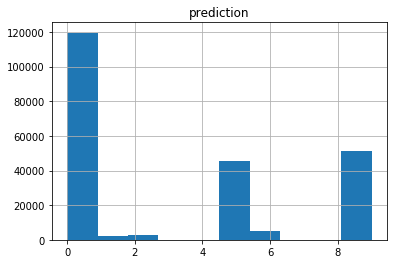

In [35]:
#pandas_testDF interpretation in graphical form suggesting number of cluster point

prediction.select("prediction").toPandas().hist();

In [36]:
prediction.groupBy('attack_cat', 'prediction').count().show()

+--------------+----------+------+
|    attack_cat|prediction| count|
+--------------+----------+------+
|      Exploits|         9|   286|
|        Normal|         2|  2605|
|       Fuzzers|         6|    16|
|Reconnaissance|         9|    74|
|      Exploits|         4|     1|
|           DoS|         9|   264|
|      Exploits|         2|     6|
|Reconnaissance|         6|    25|
|      Exploits|         6|   189|
|     Shellcode|         9|    45|
|        Normal|         4|    13|
|         Worms|         9|     7|
|       Fuzzers|         3|     1|
|       Generic|         0|119587|
|      Analysis|         6|     3|
|           DoS|         6|   111|
|        Normal|         6|  4553|
|        Normal|         8|    43|
|        Normal|         9|  3538|
|        Normal|         7|    54|
+--------------+----------+------+
only showing top 20 rows



In [37]:
prediction.select('prediction', 'attack_cat').show()

+----------+----------+
|prediction|attack_cat|
+----------+----------+
|         2|    Normal|
|         2|    Normal|
|         2|    Normal|
|         2|    Normal|
|         6|    Normal|
|         6|    Normal|
|         6|    Normal|
|         6|    Normal|
|         2|    Normal|
|         2|    Normal|
|         6|    Normal|
|         6|    Normal|
|         6|    Normal|
|         6|    Normal|
|         2|    Normal|
|         2|    Normal|
|         2|    Normal|
|         2|    Normal|
|         2|    Normal|
|         2|    Normal|
+----------+----------+
only showing top 20 rows



In [38]:
prediction.select('scaledFeatures', 'features' ,'prediction').show()

+--------------------+--------------------+----------+
|      scaledFeatures|            features|prediction|
+--------------------+--------------------+----------+
|(38,[0,1,2,7,8,9,...|(38,[0,1,2,7,8,9,...|         2|
|(38,[0,1,2,7,8,9,...|(38,[0,1,2,7,8,9,...|         2|
|(38,[1,2,7,8,9,10...|(38,[1,2,7,8,9,10...|         2|
|(38,[1,2,7,8,9,10...|(38,[1,2,7,8,9,10...|         2|
|(38,[1,9,15,26,27...|(38,[1,9,15,26,27...|         6|
|(38,[1,9,15,26,27...|(38,[1,9,15,26,27...|         6|
|(38,[1,9,15,26,27...|(38,[1,9,15,26,27...|         6|
|(38,[1,9,15,26,27...|(38,[1,9,15,26,27...|         6|
|(38,[1,2,7,8,9,10...|(38,[1,2,7,8,9,10...|         2|
|(38,[1,2,7,8,9,10...|(38,[1,2,7,8,9,10...|         2|
|(38,[1,9,15,21,26...|(38,[1,9,15,21,26...|         6|
|(38,[1,9,15,21,26...|(38,[1,9,15,21,26...|         6|
|(38,[1,9,15,21,26...|(38,[1,9,15,21,26...|         6|
|(38,[1,9,15,21,26...|(38,[1,9,15,21,26...|         6|
|(38,[0,1,2,7,8,9,...|(38,[0,1,2,7,8,9,...|         2|
|(38,[0,1,

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np

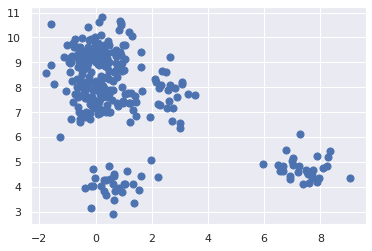

In [40]:
from sklearn.datasets.samples_generator import make_blobs
cluster_final_data, labels = make_blobs(n_samples=300, centers=centers,
                       cluster_std=0.60, random_state=0)
plt.scatter(cluster_final_data[:, 0], cluster_final_data[:, 1], s=50);

In [41]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(cluster_final_data)
y_kmeans = kmeans.predict(cluster_final_data)

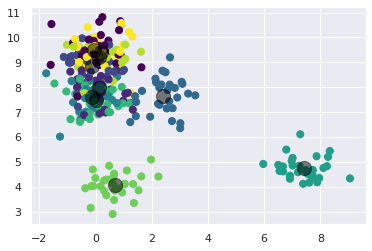

In [42]:
plt.scatter(cluster_final_data[:, 0], cluster_final_data[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [43]:
# determine k using elbow method
from scipy.spatial.distance import cdist